# CloudCast Tutorial

See here for more information:
* https://arxiv.org/abs/2007.07978
* https://vision.eng.au.dk/cloudcast-dataset/

The *CloudCast* dataset contains 70080 images with 11 different cloud types for multiple layers of the atmosphere annotated on a pixel level. The dataset has a spatial resolution of 928 x 1530 pixels recorded with 15-min intervals for the period 2017-2018, where each pixel represents an area of 3×3 km.

To enable standardized datasets for benchmarking computer vision methods, we include a full-resolution dataset centered and projected dataset over Europe (728×728). To support small-scale experiments and analysis, we also include a downsampled low-resolution dataset 128×128 (15×15 km), which is significantly smaller in size compared to the full dataset.

![title](images/example_obs-1024x206-1024x206.jpg)

## 1. Downloading CloudCast

You can download the CloudCast dataset [here](https://vision.eng.au.dk/cloudcast-dataset/). There are three versions of the dataset,
* Small Dataset (128×128, 249 MB compressed)

* Cropped Full Dataset (728×728, 8.5 GB compressed)

* Raw Full Dataset (928×1530, 328 GB compressed)

## 2. Accessing CloudCast Data

This section describes how to load CloudCast data using xarray. We will be using the full (not raw) dataset in this example.



In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.feature import BORDERS

In [2]:
# Define path to folder
path = ""

In [3]:
# Define file name (in this case, we use June 2017)
filename = path + '2017M06.nc'

In [4]:
# Load dataset using xarray
data = xr.open_dataarray(filename)

In [5]:
# Let us see how the data looks like
print(data)

<xarray.DataArray (lat: 768, lon: 768, time: 2879)>
[1698103296 values with dtype=uint8]
Coordinates:
  * lat      (lat) float64 -8.536e+05 -8.506e+05 ... 1.444e+06 1.447e+06
  * lon      (lon) float64 -2.64e+06 -2.642e+06 ... -4.938e+06 -4.940e+06
  * time     (time) datetime64[ns] 2017-06-01T00:09:17 ... 2017-06-30T23:54:17


## 3. Pre-processing to match cloud types in paper

In this section, we will do some minor pre-processing to match the cloud types described in our paper.



__First__, we remove classes 1, 2, 3 and 4, which are ```cloud-free land```, ```cloud-free sea```, ```snow over land``` and ```sea ice```. I.e., classes that are not actual cloud types. 

__Next__, we subtract 4 to match the integer values from our paper and set NaNs = 0, i.e.,


| Class | Cloud Type | 
| --- | --- |
| 0 |  No clouds or missing data |
| 1 |  Very low clouds |
| 2 |  Low clouds |
| 3 |  Mid-level clouds |
| 4 |  High opaque clouds |
| 5 |  Very high opaque clouds |
| 6 |  Fractional clouds |
| 7 |  High semitransparent thin clouds |
| 8 |  High semitransparent moderately thick clouds |
| 9 |  High semitransparent thick clouds |
| 10 |  High semitransparent above low or medium clouds |


In [6]:
# Remove cloud-free land, cloud-free sea, snow over land and sea ice
data = data.where(data>4)

In [7]:
# Subtract 4
data = data-4

In [8]:
# Set nans to zero
data = data.fillna(0)

## 4. Descriptive statistics on CloudCast Data

In this section, we will compute some minimal descriptive statistics for our dataset.


### 4.1 Frequency of cloud types

In [9]:
cloud_counts = {i:0 for i in range(0,11)}
total_count = data.shape[0] * data.shape[1] * data.shape[2]

In [10]:
for cloud_type in cloud_counts.keys():
    print(cloud_type)
    cloud_counts[cloud_type] = ((data == cloud_type).sum() / total_count).item()

0
1
2
3
4
5
6
7
8
9
10


Text(0, 0.5, 'Frequency (%)')

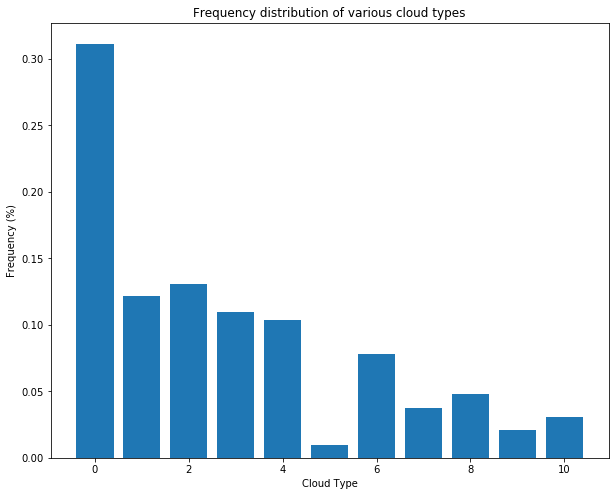

In [11]:
fig = plt.figure(figsize=(10,8))
plt.bar(cloud_counts.keys(), cloud_counts.values())
plt.title('Frequency distribution of various cloud types')
plt.xlabel('Cloud Type')
plt.ylabel('Frequency (%)')

# 4.2 Descriptive statistics

In [12]:
print('Minimum is {}'.format(data.min().item()))
print('Maximum is {}'.format(data.max().item()))
print('Mean is {}'.format(data.mean().item()))
print('Median is {}'.format(data.median().item()))
print('Standard Deviation is {}'.format(data.std().item()))

Minimum is 0.0
Maximum is 10.0
Mean is 2.7742506519462053
Median is 2.0
Standard Deviation is 2.8695599535735954


## 5. Visualizing CloudCast Data
In this section we will plot a single observation to demonstrate how CloudCast looks like for a given timestamp.

In [13]:
# change matplotlib colors slightly (optional)
blues = matplotlib.cm.get_cmap('Blues', 12)
newcolors = blues(np.linspace(0, 1, 256))
newcolors[:, :] *= 0.9  # make colors less white
newcmp = matplotlib.colors.ListedColormap(newcolors)

In [14]:
# Let us plot a single example
data_single = data.isel(time=40)

# For plotting purposes, we remove 0 (so we can actually see land)
data_single = data_single.where(data_single>0)

__Let us plot the image.__

Here, I use a NASA image as background from this site: https://visibleearth.nasa.gov/images/73826/october-blue-marble-next-generation-w-topography-and-bathymetry. 

It requires a little fiddling around in the cartopy folder (specifically, the /data/raster/natural_earth folder), so consider the line ```ax.background_img(name='BM', resolution='low')``` optional.

In [21]:
use_nasa_background = True  # set this false if you do not want background image

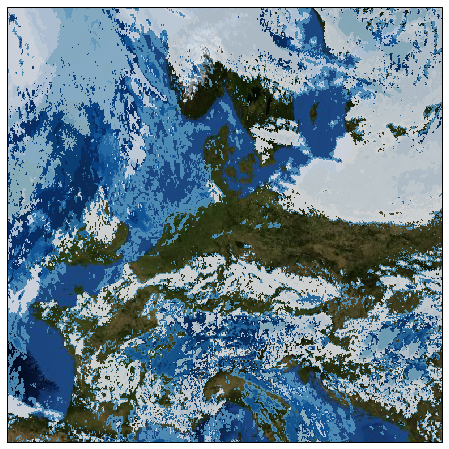

In [22]:
if use_nasa_background:
    from pyresample.geometry import AreaDefinition

    " SPECIFIC PROJECTION "
    height = 768   # 3000 resolution
    width = 768

    lower_left_xy = [-855100.436345, -4942000.0]
    upper_right_xy = [1448899.563655, -2638000.0]
    area_def = AreaDefinition('areaD', 'Europe', 'areaD',
                              {'lat_0': '90.00', 'lat_ts': '50.00',
                               'lon_0': '5', 'proj': 'stere', 'ellps': 'WGS84'},
                              height, width,
                              (lower_left_xy[0], lower_left_xy[1],
                               upper_right_xy[0], upper_right_xy[1]))
    
    crs = area_def.to_cartopy_crs()
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=crs)
    ax.background_img(name='BM', resolution='low')  
    plt.imshow(data_single.values, cmap=newcmp, transform=crs, extent=crs.bounds, origin='upper')
    
else:

    fig = plt.figure(figsize=(10,8))
    map_proj = ccrs.PlateCarree()
    ax = plt.subplot(projection=map_proj)
    data_single.plot.imshow(ax=ax, cmap=newcmp, transform=map_proj, origin='Upper')
    plt.show() 

# License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"></a><br>This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Citation
If you use this dataset in your research or elsewhere, please cite/reference the following paper:  

[CloudCast: A Satellite-Based Dataset and Baseline for Forecasting Clouds](https://arxiv.org/abs/2007.07978)


```
@article{nielsen2020cloudcast,
     title={CloudCast: A Satellite-Based Dataset and Baseline for Forecasting Clouds},
     author={A. H. Nielsen and A. Iosifidis and H. Karstoft},
     year={2020},
     eprint={2007.07978},
     archivePrefix={arXiv},
     url={https://arxiv.org/abs/2007.07978}, 
     primaryClass={cs.CV}
 } 
 ```

# Contribution
If you have any suggestions to the following, feel free to open a pull request or issue and I will add it!